In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
(x_train,_),(_,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


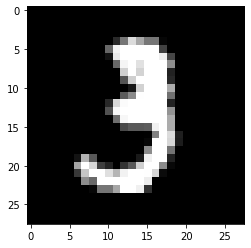

In [3]:
plt.imshow(x_train[10],cmap = 'gray')
plt.show()

In [0]:
#Normalize this data in [-1,1] range
x_train = (x_train.astype('float32')-127.5)/127.5

In [0]:
Total_epochs = 50
Batch_size = 256
Batches = int(x_train.shape[0]/Batch_size)
Half_batch = 128
Noise_Dim = 100 #Will Upsample it to 784 dimension
from keras.optimizers import Adam
adam = Adam(lr = 2e-4,beta_1=0.5)


In [6]:
generator = Sequential()
generator.add(Dense(256,input_shape = (Noise_Dim,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation = 'tanh'))

generator.compile(loss = 'binary_crossentropy',optimizer = adam)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [8]:
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation = 'sigmoid'))
discriminator.compile(loss = 'binary_crossentropy',optimizer = adam)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
#GAN step-2
discriminator.trainable = False
inp = Input(shape = (Noise_Dim,))
gen_img = generator(inp)
gen_out = discriminator(gen_img)

#Functional Api
model = Model(inp,gen_out)
model.compile(optimizer = adam,loss= 'binary_crossentropy')

In [0]:
x_train = x_train.reshape(-1,784)

In [0]:
def save_imgs(epoch,samples=100):
    
    noise = np.random.normal(0,1,size=(samples,Noise_Dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epochs 1 Disc loss 0.5555 Generator Loss 1.3936
epochs 2 Disc loss 0.5710 Generator Loss 1.3145
epochs 3 Disc loss 0.5857 Generator Loss 1.2451
epochs 4 Disc loss 0.6248 Generator Loss 1.1417
epochs 5 Disc loss 0.6385 Generator Loss 1.0816


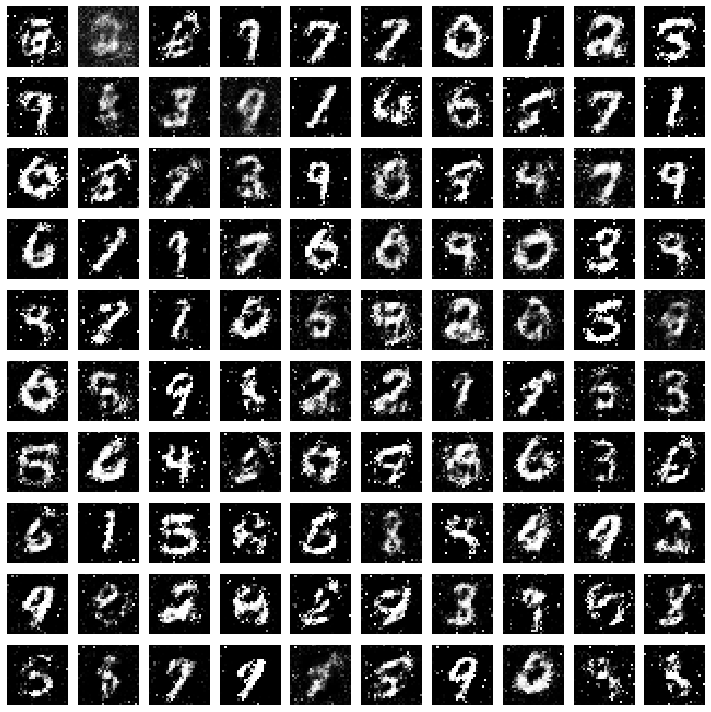

epochs 6 Disc loss 0.6299 Generator Loss 1.1002
epochs 7 Disc loss 0.6381 Generator Loss 1.0608
epochs 8 Disc loss 0.6345 Generator Loss 1.0650
epochs 9 Disc loss 0.6304 Generator Loss 1.0843
epochs 10 Disc loss 0.6335 Generator Loss 1.0727
epochs 11 Disc loss 0.6365 Generator Loss 1.0699
epochs 12 Disc loss 0.6362 Generator Loss 1.0621
epochs 13 Disc loss 0.6380 Generator Loss 1.0713
epochs 14 Disc loss 0.6425 Generator Loss 1.0593
epochs 15 Disc loss 0.6454 Generator Loss 1.0465
epochs 16 Disc loss 0.6455 Generator Loss 1.0439
epochs 17 Disc loss 0.6478 Generator Loss 1.0420
epochs 18 Disc loss 0.6488 Generator Loss 1.0361
epochs 19 Disc loss 0.6499 Generator Loss 1.0344
epochs 20 Disc loss 0.6522 Generator Loss 1.0375
epochs 21 Disc loss 0.6538 Generator Loss 1.0328
epochs 22 Disc loss 0.6507 Generator Loss 1.0383
epochs 23 Disc loss 0.6493 Generator Loss 1.0367
epochs 24 Disc loss 0.6528 Generator Loss 1.0321
epochs 25 Disc loss 0.6535 Generator Loss 1.0337
epochs 26 Disc loss 0.65

In [17]:
#Training Loop
for epoch in range(Total_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    for steps in range(Batches):
        #step 1 = Discrminator
        # 50% real data + 50% fake data
        
        #Real Data
        idx = np.random.randint(0,x_train.shape[0],Half_batch)
        real_imgs = x_train[idx]
        
        #fake data
        noise = np.random.normal(0,1,size = (Half_batch,Noise_Dim))
        fake_imgs = generator.predict(noise) #Forward pass only
        
        #Labels
        real_y = np.ones((Half_batch,1))*0.9
        fake_y = np.zeros((Half_batch,1))
        
        #Train our discrminator
        d_real_loss = discriminator.train_on_batch(real_imgs,real_y)
        d_fake_loss = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*d_real_loss+0.5*d_fake_loss
        
        epoch_d_loss += d_loss
        
        #Train_Generator Considering Frozen Discrminator
        
        noise = np.random.normal(0,1,size = (Batch_size,Noise_Dim))
        ground_truth = np.ones((Batch_size,1))
        g_loss = model.train_on_batch(noise,ground_truth)
        epoch_g_loss += g_loss
        
    print("epochs %d Disc loss %.4f Generator Loss %.4f" %((epoch+1),epoch_d_loss/Batches,epoch_g_loss/Batches))
    if (epoch+1)==5:
        generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)

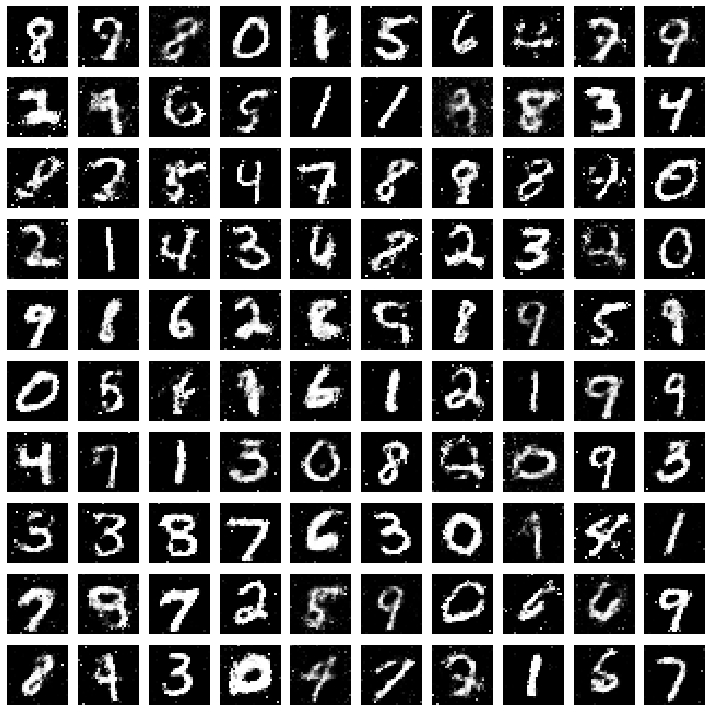

In [24]:
save_imgs(10,100)